In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

# Set seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [3]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170508288/170498071 [==============================] - 3s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [5]:
def get_preprocessing():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="preprocessing",
    )
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model

In [6]:
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem

In [7]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x

In [8]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]

In [9]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights

In [10]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = tf.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()

In [11]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)


Epoch 1/50
313/313 [==============================] - 88s 223ms/step - loss: 1.9637 - accuracy: 0.2636 - top-5-accuracy: 0.7787 - val_loss: 1.7190 - val_accuracy: 0.3789 - val_top-5-accuracy: 0.8526
Epoch 2/50
313/313 [==============================] - 67s 215ms/step - loss: 1.5469 - accuracy: 0.4216 - top-5-accuracy: 0.9099 - val_loss: 1.4683 - val_accuracy: 0.4422 - val_top-5-accuracy: 0.9251
Epoch 3/50
313/313 [==============================] - 67s 215ms/step - loss: 1.3317 - accuracy: 0.5123 - top-5-accuracy: 0.9370 - val_loss: 1.3567 - val_accuracy: 0.5128 - val_top-5-accuracy: 0.9300
Epoch 4/50
313/313 [==============================] - 67s 215ms/step - loss: 1.1643 - accuracy: 0.5827 - top-5-accuracy: 0.9565 - val_loss: 1.1477 - val_accuracy: 0.5918 - val_top-5-accuracy: 0.9455
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.6346 - top-5-accuracy: 0.9660

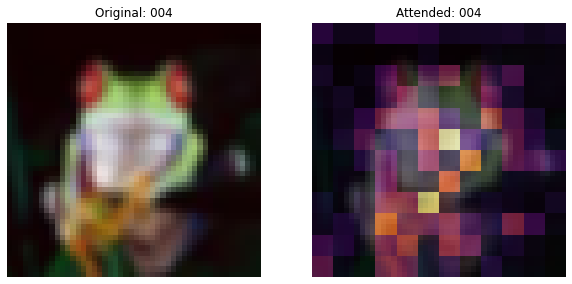

313/313 [==============================] - 67s 216ms/step - loss: 1.0240 - accuracy: 0.6346 - top-5-accuracy: 0.9660 - val_loss: 0.9302 - val_accuracy: 0.6715 - val_top-5-accuracy: 0.9702
Epoch 6/50
313/313 [==============================] - 67s 215ms/step - loss: 0.9178 - accuracy: 0.6733 - top-5-accuracy: 0.9737 - val_loss: 0.9207 - val_accuracy: 0.6799 - val_top-5-accuracy: 0.9717
Epoch 7/50
313/313 [==============================] - 67s 215ms/step - loss: 0.8292 - accuracy: 0.7076 - top-5-accuracy: 0.9785 - val_loss: 0.8361 - val_accuracy: 0.7121 - val_top-5-accuracy: 0.9779
Epoch 8/50
313/313 [==============================] - 67s 215ms/step - loss: 0.7515 - accuracy: 0.7373 - top-5-accuracy: 0.9824 - val_loss: 0.7709 - val_accuracy: 0.7301 - val_top-5-accuracy: 0.9816
Epoch 9/50
313/313 [==============================] - 67s 215ms/step - loss: 0.6825 - accuracy: 0.7628 - top-5-accuracy: 0.9865 - val_loss: 0.7586 - val_accuracy: 0.7430 - val_top-5-accuracy: 0.9818
Epoch 10/50
313/

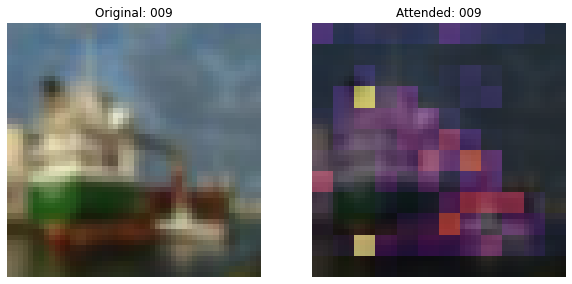

313/313 [==============================] - 68s 216ms/step - loss: 0.6291 - accuracy: 0.7824 - top-5-accuracy: 0.9880 - val_loss: 0.6898 - val_accuracy: 0.7646 - val_top-5-accuracy: 0.9844
Epoch 11/50
313/313 [==============================] - 67s 215ms/step - loss: 0.5839 - accuracy: 0.7971 - top-5-accuracy: 0.9898 - val_loss: 0.7890 - val_accuracy: 0.7481 - val_top-5-accuracy: 0.9791
Epoch 12/50
313/313 [==============================] - 67s 215ms/step - loss: 0.5561 - accuracy: 0.8067 - top-5-accuracy: 0.9903 - val_loss: 0.6124 - val_accuracy: 0.7951 - val_top-5-accuracy: 0.9871
Epoch 13/50
313/313 [==============================] - 67s 215ms/step - loss: 0.5238 - accuracy: 0.8196 - top-5-accuracy: 0.9922 - val_loss: 0.5817 - val_accuracy: 0.7964 - val_top-5-accuracy: 0.9888
Epoch 14/50
313/313 [==============================] - 67s 215ms/step - loss: 0.4979 - accuracy: 0.8268 - top-5-accuracy: 0.9928 - val_loss: 0.5818 - val_accuracy: 0.8031 - val_top-5-accuracy: 0.9887
Epoch 15/50


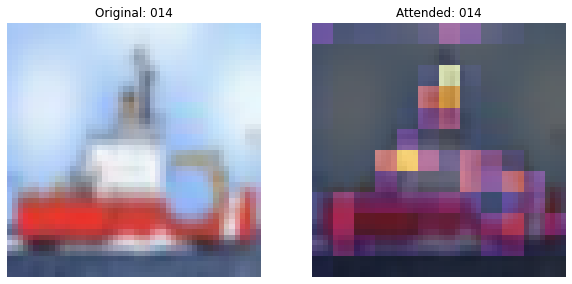

313/313 [==============================] - 68s 216ms/step - loss: 0.4807 - accuracy: 0.8339 - top-5-accuracy: 0.9937 - val_loss: 0.6189 - val_accuracy: 0.7930 - val_top-5-accuracy: 0.9874
Epoch 16/50
313/313 [==============================] - 67s 215ms/step - loss: 0.4699 - accuracy: 0.8373 - top-5-accuracy: 0.9936 - val_loss: 0.5919 - val_accuracy: 0.7942 - val_top-5-accuracy: 0.9877
Epoch 17/50
313/313 [==============================] - 67s 215ms/step - loss: 0.4391 - accuracy: 0.8491 - top-5-accuracy: 0.9947 - val_loss: 0.5613 - val_accuracy: 0.8115 - val_top-5-accuracy: 0.9892
Epoch 18/50
313/313 [==============================] - 67s 215ms/step - loss: 0.4167 - accuracy: 0.8539 - top-5-accuracy: 0.9951 - val_loss: 0.5473 - val_accuracy: 0.8160 - val_top-5-accuracy: 0.9900
Epoch 19/50
313/313 [==============================] - 67s 215ms/step - loss: 0.4021 - accuracy: 0.8614 - top-5-accuracy: 0.9953 - val_loss: 0.5347 - val_accuracy: 0.8156 - val_top-5-accuracy: 0.9904
Epoch 20/50


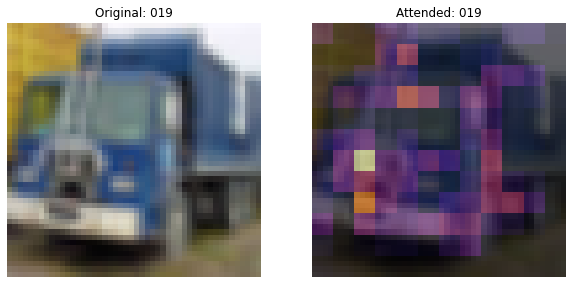

313/313 [==============================] - 67s 215ms/step - loss: 0.3817 - accuracy: 0.8672 - top-5-accuracy: 0.9958 - val_loss: 0.5160 - val_accuracy: 0.8291 - val_top-5-accuracy: 0.9911
Epoch 21/50
313/313 [==============================] - 67s 215ms/step - loss: 0.3617 - accuracy: 0.8746 - top-5-accuracy: 0.9968 - val_loss: 0.5013 - val_accuracy: 0.8322 - val_top-5-accuracy: 0.9911
Epoch 22/50
313/313 [==============================] - 67s 215ms/step - loss: 0.3429 - accuracy: 0.8795 - top-5-accuracy: 0.9972 - val_loss: 0.5215 - val_accuracy: 0.8286 - val_top-5-accuracy: 0.9915
Epoch 23/50
313/313 [==============================] - 67s 215ms/step - loss: 0.3322 - accuracy: 0.8854 - top-5-accuracy: 0.9972 - val_loss: 0.5357 - val_accuracy: 0.8253 - val_top-5-accuracy: 0.9908
Epoch 24/50
313/313 [==============================] - 67s 215ms/step - loss: 0.3145 - accuracy: 0.8906 - top-5-accuracy: 0.9976 - val_loss: 0.5162 - val_accuracy: 0.8340 - val_top-5-accuracy: 0.9930
Epoch 25/50


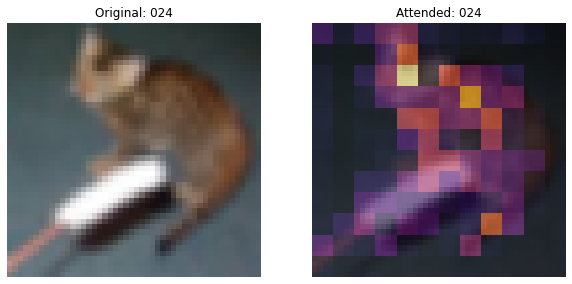

313/313 [==============================] - 67s 215ms/step - loss: 0.2913 - accuracy: 0.8995 - top-5-accuracy: 0.9977 - val_loss: 0.5301 - val_accuracy: 0.8260 - val_top-5-accuracy: 0.9906
Epoch 26/50
313/313 [==============================] - 67s 215ms/step - loss: 0.2757 - accuracy: 0.9051 - top-5-accuracy: 0.9980 - val_loss: 0.5188 - val_accuracy: 0.8319 - val_top-5-accuracy: 0.9928
Epoch 27/50
313/313 [==============================] - 67s 215ms/step - loss: 0.2698 - accuracy: 0.9066 - top-5-accuracy: 0.9982 - val_loss: 0.4979 - val_accuracy: 0.8393 - val_top-5-accuracy: 0.9915
Epoch 28/50
313/313 [==============================] - 67s 215ms/step - loss: 0.2497 - accuracy: 0.9122 - top-5-accuracy: 0.9987 - val_loss: 0.4930 - val_accuracy: 0.8387 - val_top-5-accuracy: 0.9934
Epoch 29/50
313/313 [==============================] - 67s 215ms/step - loss: 0.2394 - accuracy: 0.9177 - top-5-accuracy: 0.9987 - val_loss: 0.4769 - val_accuracy: 0.8447 - val_top-5-accuracy: 0.9935
Epoch 30/50


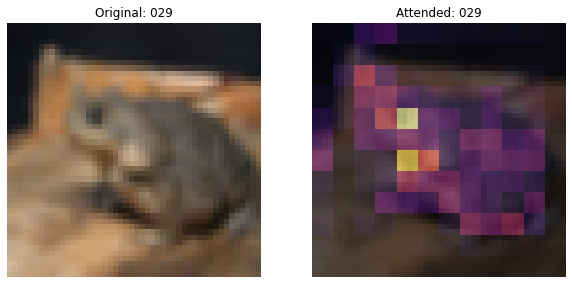

313/313 [==============================] - 67s 216ms/step - loss: 0.2190 - accuracy: 0.9212 - top-5-accuracy: 0.9989 - val_loss: 0.5027 - val_accuracy: 0.8465 - val_top-5-accuracy: 0.9933
Epoch 31/50
313/313 [==============================] - 67s 215ms/step - loss: 0.2092 - accuracy: 0.9261 - top-5-accuracy: 0.9990 - val_loss: 0.5214 - val_accuracy: 0.8451 - val_top-5-accuracy: 0.9920
Epoch 32/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1906 - accuracy: 0.9346 - top-5-accuracy: 0.9991 - val_loss: 0.5103 - val_accuracy: 0.8479 - val_top-5-accuracy: 0.9934
Epoch 33/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1781 - accuracy: 0.9388 - top-5-accuracy: 0.9993 - val_loss: 0.5301 - val_accuracy: 0.8474 - val_top-5-accuracy: 0.9931
Epoch 34/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1644 - accuracy: 0.9447 - top-5-accuracy: 0.9994 - val_loss: 0.4900 - val_accuracy: 0.8564 - val_top-5-accuracy: 0.9948
Epoch 35/50


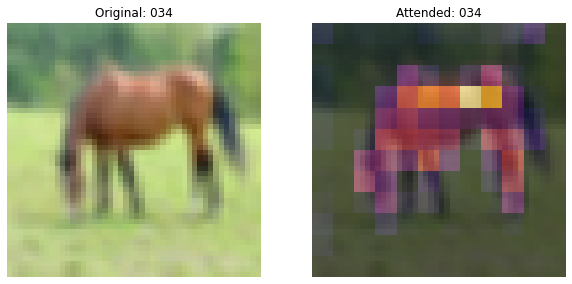

313/313 [==============================] - 67s 216ms/step - loss: 0.1505 - accuracy: 0.9477 - top-5-accuracy: 0.9995 - val_loss: 0.5378 - val_accuracy: 0.8481 - val_top-5-accuracy: 0.9932
Epoch 36/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1430 - accuracy: 0.9516 - top-5-accuracy: 0.9995 - val_loss: 0.5144 - val_accuracy: 0.8544 - val_top-5-accuracy: 0.9930
Epoch 37/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1228 - accuracy: 0.9575 - top-5-accuracy: 0.9997 - val_loss: 0.5390 - val_accuracy: 0.8552 - val_top-5-accuracy: 0.9917
Epoch 38/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1145 - accuracy: 0.9613 - top-5-accuracy: 0.9998 - val_loss: 0.5106 - val_accuracy: 0.8606 - val_top-5-accuracy: 0.9941
Epoch 39/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1123 - accuracy: 0.9607 - top-5-accuracy: 0.9997 - val_loss: 0.5564 - val_accuracy: 0.8524 - val_top-5-accuracy: 0.9916
Epoch 40/50


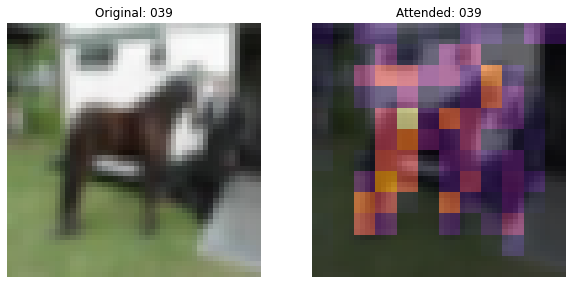

313/313 [==============================] - 67s 216ms/step - loss: 0.1006 - accuracy: 0.9656 - top-5-accuracy: 0.9998 - val_loss: 0.5335 - val_accuracy: 0.8569 - val_top-5-accuracy: 0.9919
Epoch 41/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0900 - accuracy: 0.9694 - top-5-accuracy: 0.9999 - val_loss: 0.5392 - val_accuracy: 0.8567 - val_top-5-accuracy: 0.9916
Epoch 42/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0857 - accuracy: 0.9717 - top-5-accuracy: 0.9999 - val_loss: 0.5285 - val_accuracy: 0.8623 - val_top-5-accuracy: 0.9925
Epoch 43/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0788 - accuracy: 0.9742 - top-5-accuracy: 0.9998 - val_loss: 0.5110 - val_accuracy: 0.8652 - val_top-5-accuracy: 0.9936
Epoch 44/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0766 - accuracy: 0.9737 - top-5-accuracy: 0.9999 - val_loss: 0.4956 - val_accuracy: 0.8689 - val_top-5-accuracy: 0.9932
Epoch 45/50


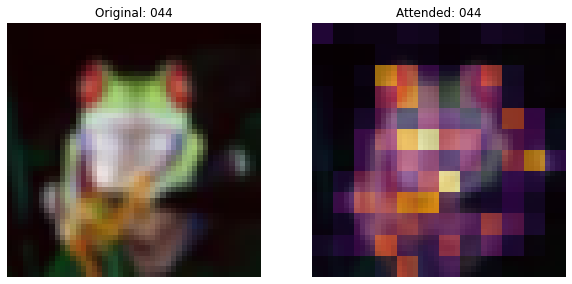

313/313 [==============================] - 67s 215ms/step - loss: 0.0756 - accuracy: 0.9762 - top-5-accuracy: 0.9999 - val_loss: 0.4973 - val_accuracy: 0.8660 - val_top-5-accuracy: 0.9915
Epoch 46/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0794 - accuracy: 0.9743 - top-5-accuracy: 0.9998 - val_loss: 0.4796 - val_accuracy: 0.8630 - val_top-5-accuracy: 0.9927
Epoch 47/50
313/313 [==============================] - 67s 215ms/step - loss: 0.0888 - accuracy: 0.9724 - top-5-accuracy: 0.9998 - val_loss: 0.4614 - val_accuracy: 0.8648 - val_top-5-accuracy: 0.9928
Epoch 48/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1037 - accuracy: 0.9672 - top-5-accuracy: 0.9998 - val_loss: 0.4426 - val_accuracy: 0.8655 - val_top-5-accuracy: 0.9933
Epoch 49/50
313/313 [==============================] - 67s 215ms/step - loss: 0.1321 - accuracy: 0.9602 - top-5-accuracy: 0.9996 - val_loss: 0.4394 - val_accuracy: 0.8618 - val_top-5-accuracy: 0.9928
Epoch 50/50


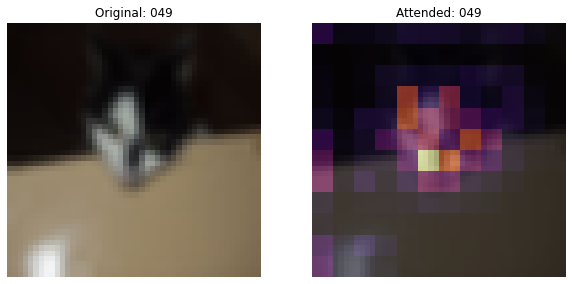

79/79 [==============================] - 5s 62ms/step - loss: 0.4689 - accuracy: 0.8464 - top-5-accuracy: 0.9933
Loss: 0.47
Top 1 test accuracy: 84.64%
Top 5 test accuracy: 99.33%


In [12]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_convnet = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_convnet.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_convnet.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_convnet.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

  16384/Unknown - 0s 0us/step

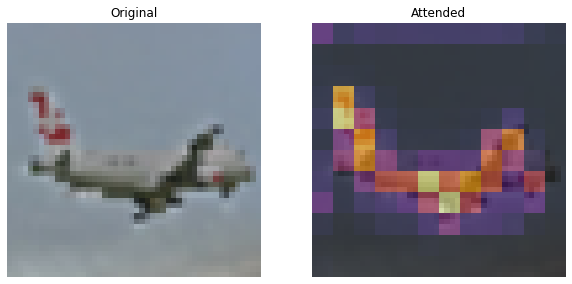

In [13]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_convnet.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_convnet.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_convnet.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_convnet.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
image_name = keras.utils.get_file(fname="image.jpg", origin=url)
image = tf.io.read_file(image_name)
image = tf.io.decode_image(image)
plot_attention(image)